# <center>Бинарная классификация и отправка на Kaggle

5. Во вкладке Data будут данные, на которых будем обучать модель и проверять нашу модель на test выборке. В файле sample_submission пример отправленного решения. 
Приступим к решению. Рассмотрим на примере варианта из пункта b

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [5]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

### Посмотрим на данные

In [6]:
train

,id,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,...,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,4719,28,20.30,487.95,Male,0,Yes,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),0
1,3190,12,81.45,912,Male,0,No,No,Yes,No,...,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,0
2,5215,25,20.15,536.35,Male,0,No,No,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,0
3,1472,50,69.50,3418.2,Male,0,No,No,Yes,Yes,...,No,No,Yes,Yes,No,Yes,Two year,No,Bank transfer (automatic),0
4,4413,39,101.25,3949.15,Female,1,Yes,No,Yes,Yes,...,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,3483,2,79.95,174.45,Male,0,No,No,Yes,No,...,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,0
3165,3555,16,73.85,1284.2,Male,0,Yes,No,Yes,Yes,...,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1
3166,2292,50,70.35,3454.6,Male,1,No,No,Yes,Yes,...,Yes,Yes,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),0
3167,960,54,55.00,3092.65,Male,0,No,Yes,Yes,Yes,...,No,Yes,No,No,No,No,Month-to-month,Yes,Credit card (automatic),1


In [71]:
test.head()

,id,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,2258,46,55.65,2688.85,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,Yes,One year,No,Credit card (automatic)
1,3864,48,78.75,3682.45,Male,0,No,Yes,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic)
2,1391,7,69.20,477.55,Female,0,Yes,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic)
3,486,3,75.15,216.75,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)
4,970,14,19.35,324.8,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check


Датасеты train и test отличаются толькой одной колонкой - той, что надо предсказать. 
Посмотрим на количество пропусков в каждой колонке

In [8]:
train.isna().any(axis=1).sum()

0

In [9]:
test.isna().any(axis=1).sum()

0

Вообще, isna находит не все пропуски. 
Например, если внезапно численная переменная вдруг становится строкой - это звоночек, что там есть какие-то проблемы.
Поэтому рекомендуется у строк, которые не являются численными (int64, float64), выводить уникальные значения. 
Там и можно обнаружить пропуски

### Посмотрим на тип данных каждой из колонок

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        3169 non-null   int64  
 1   ClientPeriod              3169 non-null   int64  
 2   MonthlySpending           3169 non-null   float64
 3   TotalSpent                3169 non-null   object 
 4   Sex                       3169 non-null   object 
 5   IsSeniorCitizen           3169 non-null   int64  
 6   HasPartner                3169 non-null   object 
 7   HasChild                  3169 non-null   object 
 8   HasPhoneService           3169 non-null   object 
 9   HasMultiplePhoneNumbers   3169 non-null   object 
 10  HasInternetService        3169 non-null   object 
 11  HasOnlineSecurityService  3169 non-null   object 
 12  HasOnlineBackup           3169 non-null   object 
 13  HasDeviceProtection       3169 non-null   object 
 14  HasTechS

In [11]:
train.describe()

,id,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000
mean,2658.504891,31.855790,65.157715,0.162512,0.265068
std,1536.114959,24.471827,29.921808,0.368978,0.441439
min,1.000000,0.000000,18.250000,0.000000,0.000000
25%,1330.000000,8.000000,39.200000,0.000000,0.000000
50%,2635.000000,28.000000,70.700000,0.000000,0.000000
75%,4027.000000,54.000000,89.850000,0.000000,1.000000
max,5279.000000,72.000000,118.650000,1.000000,1.000000


In [17]:
# здесь есть ловушка, поищите
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'IsSeniorCitizen'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'HasPartner',
    'TotalSpent',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols
target_col = 'Churn'

В sklearn большинство моделей не обрабатывают категориальные признаки.
А у нас они есть... поэтому вспоминаем первую практическую и обрабатываем категориальные признаки.
Также, мы применяли one-hot encoding к категориальным признакам, потому что с label-encoding в случае 3 и более значений образовывались операции +- над категориями. 
Но вспомним, что после one-hot encoding мы получали бинарные данные, а некоторые из признаков и так уже бинарные.

А еще можно обрабатывать числовые признаки. Можно же?

## Обработка

In [16]:
for i in cat_cols:
    print(f'{i} - {train[i].unique()}')

Sex - ['Male' 'Female']
HasPartner - ['Yes' 'No']
TotalSpent - ['487.95' '912' '536.35' ... '3454.6' '3092.65' '1043.8']
HasChild - ['Yes' 'No']
HasPhoneService - ['Yes' 'No']
HasMultiplePhoneNumbers - ['No' 'Yes' 'No phone service']
HasInternetService - ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService - ['No internet service' 'No' 'Yes']
HasOnlineBackup - ['No internet service' 'No' 'Yes']
HasDeviceProtection - ['No internet service' 'No' 'Yes']
HasTechSupportAccess - ['No internet service' 'No' 'Yes']
HasOnlineTV - ['No internet service' 'Yes' 'No']
HasMovieSubscription - ['No internet service' 'No' 'Yes']
HasContractPhone - ['Two year' 'Month-to-month' 'One year']
IsBillingPaperless - ['Yes' 'No']
PaymentMethod - ['Credit card (automatic)' 'Electronic check' 'Mailed check'
 'Bank transfer (automatic)']


Видим что столбец TotalSpent является числовым

In [42]:
def num_unique(data: pd.core.frame.DataFrame, column: str) -> set:
    """
    Функция поиска уникальных значений среди чисел
    :param data: датафрейм
    :type data: pd.core.frame.DataFrame
    :param column: название столбца
    :type column: str
    :return: множество уникальных значений
    :rtype: set
    """
    nan = set()
    for item in data[column]:
        if not ('.' or ',') in item and not item.isdigit():
            nan.add(item)
    return nan


In [38]:
num_unique(train, 'TotalSpent')

{' '}

Заменяем нечисловые значения и приводим к float

In [ ]:
train['TotalSpent'] = train['TotalSpent'].replace({' ': np.nan})
train['TotalSpent'] = train['TotalSpent'].astype(float)

num_cols.append('TotalSpent')
cat_cols.remove('TotalSpent')

In [56]:
x = train[num_cols]
y = train[target_col]

Посмотрим на распеределение значения целевой переменной

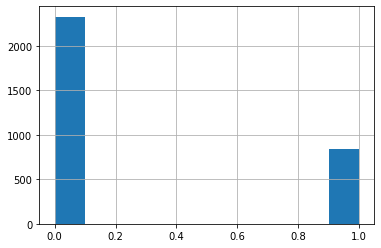

In [50]:
y.hist()
plt.show()

### Можем заметить, что Y несбалансирован
### Поэтому предсказательную способность модели будем оценивать по метрике ROC-AUC.
### Так же воспользуемся воспользуем разделением данных на тренировочную и валидационную выборку

In [57]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.7)

In [58]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Посмотрим на получившийся результат и построим график для ROC-AUC. Обратите внимаение, что мы предсказываем колонку 'Churn' с помощью метода predict_proba(), а почему не обычный predict() ответите на защите

In [83]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

In [84]:
y_train_predicted_knn = knn.predict_proba(x_train)[:, 1]
y_val_predicted_knn = knn.predict_proba(x_val)[:, 1]

In [85]:
def roc_auc_plot(y_train, y_train_predicted, y_val, y_val_predicted) -> None:
    train_auc = roc_auc_score(y_train, y_train_predicted)
    test_auc = roc_auc_score(y_val, y_val_predicted)

    plt.figure(figsize=(10,7))
    plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_val, y_val_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

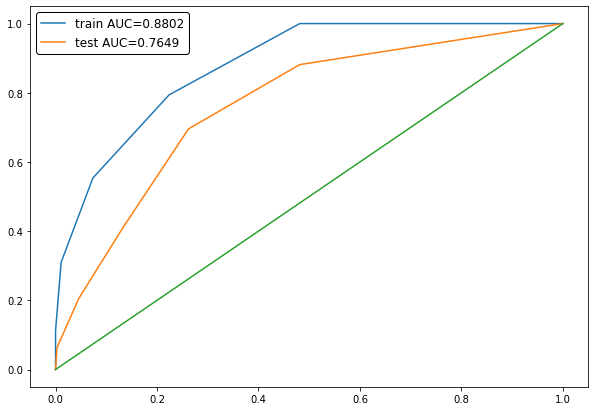

In [86]:
roc_auc_plot(y_train, y_train_predicted_knn, y_val, y_val_predicted_knn)

In [87]:
# Модель обучили теперь можно и предсказать колонку 'Churn' для test

In [88]:
# сохраним колонку с id, для файла с ответом
test_id = test['id']
test = test[num_cols]
y_test_predicted_knn = knn.predict_proba(test)[:, 1]

In [89]:
def create_submission(id_col, y_pred):
    submission = pd.DataFrame({
        'id': id_col,
        'Churn': y_pred
    })
    return submission

In [90]:
sub = create_submission(test_id, y_test_predicted_knn)

In [91]:
sub

,id,Churn
0,2258,0.0
1,3864,0.0
2,1391,0.2
3,486,0.4
4,970,0.2
...,...,...
2108,1700,0.2
2109,1865,0.0
2110,478,0.0
2111,1227,0.6


In [92]:
# сохраним файл с ответом и загрузим его для на kaggle
sub.to_csv("data_baseline//sub.csv", index=False)

### Перейдем на наше соревнование и загрузим ответ
### Для этого нажимаем на Submit Predictions
### Загружаем файл с ответом
### Нажимаем make Submsission
### Показывается наш результат
### Переходим во вкладку Leaderboard, что бы посмотреть на место, которые мы заняли

### Советы для улучшения результата
1. Построить графики для данных и поискать закономерности 
2. Нормальная предобработка признаков, отбор признаков, создание новых признаков
3. Попробовать другие модели
4. Перебор параметров для моделей
5. Погуглить про задачу и посмотреть, как люди подходят к решению задачи классификации